# Introduction

Tasked with providing understanding into customer characteristics which help generate higher revenues, and those which lead to success for a cross sell promotion, the following the key insights and recommendations were developed from our analysis.

# Feature engineering

In [1]:
#############################
# Importing libraries & data
#############################


# importing libraries
import pandas as pd # data science essentials
import matplotlib.pyplot as plt # essential graphical output
import seaborn as sns # enhanced graphical output
import numpy as np # mathematical essentials
import statsmodels.formula.api as smf # regression modeling
from sklearn.model_selection import train_test_split # train/test split
from sklearn.model_selection import RandomizedSearchCV #  hyperparameter tuning
from sklearn.linear_model import LinearRegression # linear regression
#from sklearn.linear_model import LogisticRegression # logistic regression
#from sklearn.linear_model import Lasso # Lasso for regression
#from sklearn.linear_model import ARDRegression # ARDRegression for regression
#from sklearn.neighbors import KNeighborsRegressor # KNN for Regression
#from sklearn.neighbors import KNeighborsClassifier # KNN for Regression
from sklearn.preprocessing import StandardScaler # standard scaler
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.metrics import make_scorer              # customizable scorer
#from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm

# for classification trees
#from sklearn.tree import DecisionTreeClassifier      # classification trees
#from sklearn.tree import export_graphviz             # exports graphics
#from six import StringIO           # saves objects in memory
#from IPython.display import Image                    # displays on frontend
#import pydotplus                                     # interprets dot objects


# Importing dataset
file = 'Apprentice_Chef_Dataset.xlsx'
ap_chef = pd.read_excel(io=file)


# Importing gender data
file = './gender.xlsx'
gender = pd.read_excel(file)


#############################
# Feature engineering
#############################


##########
# Renaming columns
##########

# LARGEST_ORDER_SIZE is incorrectly labelled and should be AVERAGE_MEALS_PER_CUST
ap_chef = ap_chef.rename(columns={'LARGEST_ORDER_SIZE' : 'AVERAGE_MEALS_PER_CUST'})
# PC_LOGINS in misleading - actually represents TOTAL_LOGINS
ap_chef = ap_chef.rename(columns={'PC_LOGINS' : 'TOTAL_LOGINS'})


##########
# combining variables
##########

ap_chef['CANCELLATIONS_BN_TMO']  = ap_chef['CANCELLATIONS_BEFORE_NOON']   / ap_chef['TOTAL_MEALS_ORDERED']
ap_chef['CANCELLATIONS_AN_TMO']  = ap_chef['CANCELLATIONS_AFTER_NOON']    / ap_chef['TOTAL_MEALS_ORDERED']
ap_chef['CUST_SERVICE_TMO']      = ap_chef['CONTACTS_W_CUSTOMER_SERVICE'] / ap_chef['TOTAL_MEALS_ORDERED']
ap_chef['UNIQUE_MEALS_TMO']      = ap_chef['UNIQUE_MEALS_PURCH']          / ap_chef['TOTAL_MEALS_ORDERED']
ap_chef['REVENUE_TMO']           = ap_chef['REVENUE']                     / ap_chef['TOTAL_MEALS_ORDERED']
ap_chef['CATEGORY_UNIQUE_ORDER'] = ap_chef['PRODUCT_CATEGORIES_VIEWED']   / ap_chef['UNIQUE_MEALS_PURCH']


##########
# log transformations
##########

ap_chef['log_REVENUE']               = np.log10(ap_chef['REVENUE'])
ap_chef['log_TOTAL_MEALS_ORDERED']   = np.log10(ap_chef['TOTAL_MEALS_ORDERED'])
ap_chef['log_AVG_PREP_VID_TIME']     = np.log10(ap_chef['AVG_PREP_VID_TIME'])
ap_chef['log_CUST_SERVICE_TMO']      = np.log10(ap_chef['CUST_SERVICE_TMO'])
ap_chef['log_UNIQUE_MEALS_TMO']      = np.log10(ap_chef['UNIQUE_MEALS_TMO'])
ap_chef['log_CATEGORY_UNIQUE_ORDER'] = np.log10(ap_chef['CATEGORY_UNIQUE_ORDER'])


##########
# flagging trends in the data
##########

ap_chef['TOTAL_MEALS_ORDERED_20']         = 0
ap_chef['TOTAL_PHOTOS_VIEWED_0']          = 0
ap_chef['CONTACTS_W_CUSTOMER_SERVICE_10'] = 0
ap_chef['AVG_CLICKS_PER_VISIT_10']        = 0
ap_chef['CUST_SERVICE_TMO_05']            = 0
ap_chef['CANCELLATIONS_BEFORE_NOON_2']    = 0
ap_chef['MOBILE_LOGINS_0']                = 0
ap_chef['WINE_def']                       = 0
ap_chef['TASTES_AND_PREFERENCES_MASTER_CLASSES_ATTENDED'] = 0

# loop to fill the new variables
for index, value in ap_chef.iterrows():

    if ap_chef.loc[index, 'TOTAL_MEALS_ORDERED'] > 20:
        ap_chef.loc[index, 'TOTAL_MEALS_ORDERED_20'] = 1
        
    if ap_chef.loc[index, 'TOTAL_PHOTOS_VIEWED'] > 0:
        ap_chef.loc[index, 'TOTAL_PHOTOS_VIEWED_0'] = 1        

    if ap_chef.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE'] > 10:
        ap_chef.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE_10'] = 1       
        
    if ap_chef.loc[index, 'AVG_CLICKS_PER_VISIT'] > 10:
        ap_chef.loc[index, 'AVG_CLICKS_PER_VISIT_10'] = 1    
        
    if ap_chef.loc[index, 'CUST_SERVICE_TMO'] > 0.5:
        ap_chef.loc[index, 'CUST_SERVICE_TMO_05'] = 1
        
    if ap_chef.loc[index, 'CANCELLATIONS_BEFORE_NOON'] >= 2:
        ap_chef.loc[index, 'CANCELLATIONS_BEFORE_NOON_2'] = 1
        
    if ap_chef.loc[index, 'MOBILE_LOGINS'] > 0:
        ap_chef.loc[index, 'MOBILE_LOGINS_0'] = 1
        
    if ap_chef.loc[index, 'REVENUE_TMO'] > 28:
        ap_chef.loc[index, 'WINE_def'] = 1
        
    if ap_chef.loc[index, 'TASTES_AND_PREFERENCES'] == 1 and \
       ap_chef.loc[index, 'MASTER_CLASSES_ATTENDED'] > 0:
        ap_chef.loc[index, 'TASTES_AND_PREFERENCES_MASTER_CLASSES_ATTENDED'] = 1
        
        
##########
# Working on categorical data
##########

# Creating new variable for email domain
ap_chef['EMAIL_GROUP'] = 0

# Creating loop to distinguish email categories
for index, obs in ap_chef.iterrows() :
    
    if 'gmail.com' in ap_chef.loc[index, 'EMAIL'] or \
            'yahoo.com' in ap_chef.loc[index, 'EMAIL'] or \
            'protonmail.com' in ap_chef.loc[index, 'EMAIL']:
        
        ap_chef.loc[index, 'EMAIL_GROUP'] = 'personal'
    
    elif 'me.com' in ap_chef.loc[index, 'EMAIL'] or \
            'aol.com' in ap_chef.loc[index, 'EMAIL'] or \
            'hotmail.com' in ap_chef.loc[index, 'EMAIL'] or \
            'live.com' in ap_chef.loc[index, 'EMAIL'] or \
            'msn.com' in ap_chef.loc[index, 'EMAIL'] or \
            'passport.com' in ap_chef.loc[index, 'EMAIL']:
        
        ap_chef.loc[index, 'EMAIL_GROUP'] = 'junk'
    
    else :
        
        ap_chef.loc[index, 'EMAIL_GROUP'] = 'professional'
        
# replacing EMAIL_GROUP with dummy variables
one_hot_EMAIL = pd.get_dummies(ap_chef['EMAIL_GROUP'])
ap_chef = ap_chef.drop('EMAIL_GROUP', axis=1)
ap_chef = ap_chef.join(one_hot_EMAIL)


# creating the new variable for gender
ap_chef['GENDER'] = 0

# loop to lookup gender in ap_chef on the gender file
index = 0

for name in ap_chef.loc[: , 'FIRST_NAME']:
    sex = gender.loc[:, 'Gender'][gender.loc[: , 'Name'] == name].to_string(index=False)
    ap_chef.loc[index, 'GENDER'] = sex
    index += 1
    
# Creating a new column to take binary data
ap_chef['female'] = 0

# iterating over original column to change values in the new feature column
for index, value in ap_chef.iterrows():

    if ap_chef.loc[index, 'GENDER'] == 'female':
        ap_chef.loc[index, 'female'] = 1

# Understanding REVENUE

## Running the model

In [2]:
# listing all significant variables
variables = ['CROSS_SELL_SUCCESS', 'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE',
             'PRODUCT_CATEGORIES_VIEWED', 'REFRIGERATED_LOCKER', 'AVERAGE_MEALS_PER_CUST',
             'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING', 'TOTAL_PHOTOS_VIEWED',
             'log_TOTAL_MEALS_ORDERED', 'log_AVG_PREP_VID_TIME', 'TOTAL_MEALS_ORDERED_20',
             'TOTAL_PHOTOS_VIEWED_0', 'CONTACTS_W_CUSTOMER_SERVICE_10', 'junk',
             'personal', 'professional', 'AVG_CLICKS_PER_VISIT_10',
             'CANCELLATIONS_AN_TMO', 'log_CUST_SERVICE_TMO', 'CUST_SERVICE_TMO_05',
             'log_UNIQUE_MEALS_TMO', 'log_CATEGORY_UNIQUE_ORDER']


# Creating X and y dataframes
X = ap_chef.loc[:, variables]
y = ap_chef.loc[:, 'log_REVENUE']


##############################
# Model on select data
##############################

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size = 0.25,
            random_state = 219)


##########
# Applying the model
##########

# INSTANTIATING a model object
lr = LinearRegression()

# FITTING to the training data
lr_fit = lr.fit(X_train, y_train)

# PREDICTING on new data
lr_pred = lr_fit.predict(X_test)

# SCORING results
train_score = lr.score(X_train, y_train).round(3)
test_score = lr.score(X_test, y_test).round(3)

# printing the results
#print('OLS Training Score :', train_score)
#print('OLS Testing Score  :', test_score)

# displaying and saving the gap between training and testing
test_gap = abs(train_score - test_score).round(3)
#print('OLS Train-Test Gap :', test_gap)


##########
# Gathering the coefficients
##########


# zipping each feature name to its coefficient
model_values = zip(X.columns,
                   lr_fit.coef_.round(decimals = 2))


# setting up a placeholder list to store model features
model_lst = [('intercept', lr_fit.intercept_.round(decimals = 2))]


# saving each feature-coefficient pair one by one
for val in model_values:
    model_lst.append(val)

# dropping coefficients that are equal to zero
for feature, coefficient in model_lst:
        if coefficient == 0:
            model_lst.remove((feature, coefficient))

# dropping coefficients that are equal to zero
for feature, coefficient in model_lst:
        if coefficient == 0:
            model_lst.remove((feature, coefficient))
            
# printing coefficients
#print("""
#Features and coefficients:""")
#for feature, coefficient in model_lst:
#        print (feature, coefficient)
        
        
##############################
# Model on standardized data
##############################
        
    
# INSTANTIATING a StandardScaler() object
scaler = StandardScaler()

# FITTING the scaler with housing_data
scaler.fit(X)

# TRANSFORMING our data after fit
X_scaled = scaler.transform(X)

# converting scaled data into a DataFrame
X_scaled_df = pd.DataFrame(X_scaled)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
            X_scaled_df,
            y,
            test_size = 0.25,
            random_state = 219)


##########
# Applying the model
##########

# INSTANTIATING a model object
lr = LinearRegression()

# FITTING to the training data
lr_fit = lr.fit(X_train, y_train)

# PREDICTING on new data
lr_pred = lr_fit.predict(X_test)

# SCORING results
train_score = lr.score(X_train, y_train).round(3)
test_score = lr.score(X_test, y_test).round(3)

# displaying and saving the gap between training and testing
test_gap = abs(train_score - test_score).round(3)


# zipping each feature name to its coefficient
model_values = zip(X.columns,
                   lr_fit.coef_.round(decimals = 2))


##########
# Gathering the coefficients
##########


# setting up a placeholder list to store model features
model_lst = [('intercept', lr_fit.intercept_.round(decimals = 2))]


# saving each feature-coefficient pair one by one
for val in model_values:
    model_lst.append(val)

# dropping coefficients that are equal to zero
for feature, coefficient in model_lst:
        if coefficient == 0:
            model_lst.remove((feature, coefficient))

# dropping coefficients that are equal to zero
for feature, coefficient in model_lst:
        if coefficient == 0:
            model_lst.remove((feature, coefficient))
            
# printing coefficients
#print("""
#Features and coefficients for standardized data:""")
#for feature, coefficient in model_lst:
#        print (feature, coefficient)

## Insights

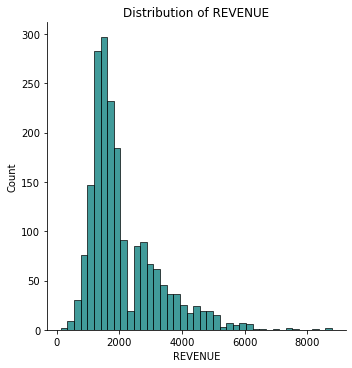

In [3]:
# Generating plot for log_REVENUE
sns.displot(x  = 'REVENUE',
            data = ap_chef,
            color = 'xkcd:bluegreen')
plt.title('Distribution of REVENUE')
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
Two segments clearly stand out when looking at the distribution of revenue:

  - the budget conscious customers (revenue < $2,200)
  - the high rollers
  
What differentiates these two groups and how can we nudge our budget conscious customers closer to this high roller group?

We have developed a linear regression model achieving an R^2 of 0.79 to answer these questions.

.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
1. The more unique meals ordered relative to total orders placed had a negative impact on predicted revenue (a 1% increase in the former led to a 0.29% decrease in the latter)
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
2. Relative number of calls placed to customer service also negatively impacted predicted revenue.

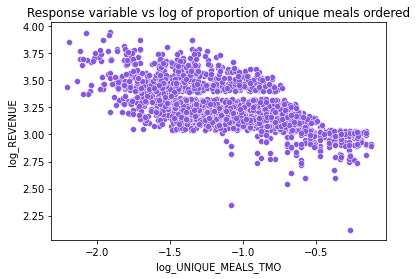

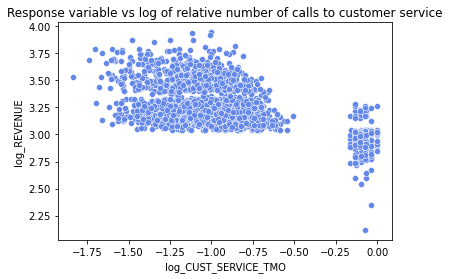

In [4]:
# Visualizing the variable
sns.scatterplot(x     = 'log_UNIQUE_MEALS_TMO',
                y     = 'log_REVENUE',
                data  = ap_chef,
                color = 'xkcd:purpley')
plt.title('Response variable vs log of proportion of unique meals ordered')
plt.show()

# Visualizing the variables
sns.scatterplot(x     = 'log_CUST_SERVICE_TMO',
                y     = 'log_REVENUE',
                data  = ap_chef,
                color = 'xkcd:soft blue')
plt.title('Response variable vs log of relative number of calls to customer service')
plt.show()

# Understanding the success of HALFWAY THERE

## Running the model

In [5]:
# listing all significant variables
variables = ['TOTAL_MEALS_ORDERED', 'CONTACTS_W_CUSTOMER_SERVICE', 'MOBILE_NUMBER',
             'CANCELLATIONS_AFTER_NOON', 'TOTAL_LOGINS', 'REFRIGERATED_LOCKER',
             'CANCELLATIONS_BEFORE_NOON_2', 'MOBILE_LOGINS_0', 'female', 'junk', 'professional', 
             'WINE_def', 'CUST_SERVICE_TMO', 'TASTES_AND_PREFERENCES_MASTER_CLASSES_ATTENDED']


# Creating X and y dataframes
X = ap_chef.loc[:, variables]
y = ap_chef.loc[:, 'CROSS_SELL_SUCCESS']


##############################
# Model on select data
##############################

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            stratify = y,
            test_size = 0.25,
            random_state = 219)


##########
# Applying the model
##########


# INSTANTIATING the model
gradient = GradientBoostingClassifier(learning_rate=0.8999999999999999, max_depth=3,
                                      n_estimators = 100, random_state = 219, warm_start = True)


# FITTING the training data
gradient_fit = gradient.fit(X, y)


# PREDICTING based on the testing set
y_pred = gradient_fit.predict(X_test)


# saving AUC score
auc_score   = roc_auc_score(y_true  = y_test,
                            y_score = y_pred).round(3)
#print('AUC Score        :', auc_score)


##########
# Gathering the coefficients
##########

# Plotting important variables
#plot_feature_importances(model = gradient_fit, train = X_train)

## Insights

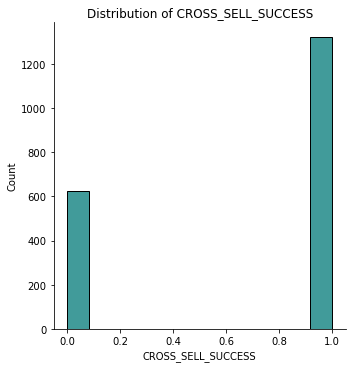

In [6]:
# Generating plot for CROSS_SELL_SUCCESS
sns.displot(x    = 'CROSS_SELL_SUCCESS',
            data = ap_chef,
            color = 'xkcd:bluegreen')
plt.title('Distribution of CROSS_SELL_SUCCESS')
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
A promotion ran to cross-sell wine was successful twice as often as not. While customer engagement is important, we must note that this success had negligible impact on revenue.

A Gradient Boosting Classification model with an AUC of 0.895 helps us understand the reasons behind the success.

.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
1. Customers who had registered 'junk' email addresses were much less likely to buy HALFWAY THERE.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
2. Buying into other optional services offered by Apprentice Chef increased the likelihood of purchasing HALFWAY THERE by 23.6%.

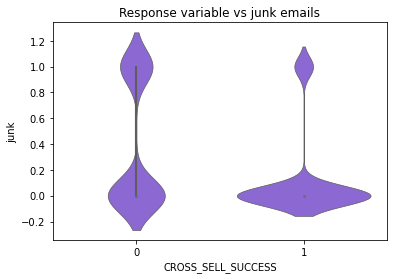

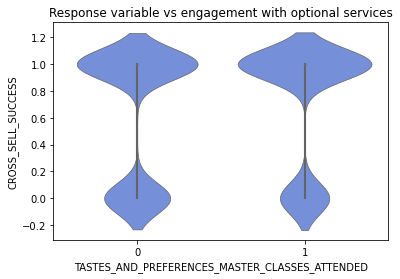

In [7]:
# Visualizing the variable
sns.violinplot(y     = 'junk',
               x     = 'CROSS_SELL_SUCCESS',
               data  = ap_chef,
               color = 'xkcd:purpley',
               linewidth = 0.7)
plt.title('Response variable vs junk emails')
plt.show()

# Visualizing the variable
sns.violinplot(x     = 'TASTES_AND_PREFERENCES_MASTER_CLASSES_ATTENDED',
               y     = 'CROSS_SELL_SUCCESS',
               data  = ap_chef,
               color = 'xkcd:soft blue',
               linewidth = 0.7)
plt.title('Response variable vs engagement with optional services')
plt.show()

# Next steps

Based on our understanding of the characteristics behind customers generating high revenue and those more inclined to adopt the cross-sell promotion, the following action items are recommended:

  1. Perform A/B testing to confirm the theory that customers are willing to spend more on meals they know they will enjoy, over trying something new they potentially won't enjoy as much. If confirmed, offers which encourage meal diversification could help customers discover more meals they enjoy and so use the service more.
  

  2. Recontact customers who have registered 'junk' email addresses via a notification on the application or website. They are most likely not seeing the information shared about the promotion and so missing out on the opportunity. Alternatively, ensure HALFWAY THERE is clearly promoted on all platforms.